In [14]:
import pysam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from icecream import ic
from Bio import SeqIO
from collections import defaultdict
from icecream import ic

# I now have a dataset that I can train an HMM on, let's see how it goes!

### Load Data

In [5]:

project_dir = Path('/data16/liam/working/data/alignments/250509_JANP-112_LT/')

bam = project_dir / '250509_JANP-112_LT.AtoG.sorted.bam'

both_bam = project_dir / 'demultiplexed_bams/bc6.bam' # both
oligo1_bam = project_dir / 'demultiplexed_bams/bc5.bam' # oligo1
oligo2_bam = project_dir / 'demultiplexed_bams/bc4.bam' # no ribosome
noOligo_bam = project_dir / 'demultiplexed_bams/bc3.bam' # time zero

merged_bam = project_dir / 'demultiplexed_bams/merged_barcodes.bam'
figures_dir = project_dir / 'figures'

out_dir = Path('/data16/liam/working/data/alignments/250509_JANP-112_LT/demultiplexed_bams/')
contig_pos_map = Path('/data16/liam/genomes/250401_translationSubstrate_pos_map.tsv')

reference = Path('/data16/liam/genomes/250401_dCDNA_translationSubstrates.fa')
assert reference.exists()
assert bam.exists()
assert out_dir.exists()
assert contig_pos_map.exists()

print('All files exist')

All files exist


In [6]:
ref_dict = SeqIO.to_dict(SeqIO.parse(reference, 'fasta'))
ref_seq = str(ref_dict['nanoluc_translatable'].seq)

In [11]:
# first lets get every read, identify edits, and convert the reads to binary strings. We'll want to do this by alignment
def get_binary_edit_string(bam, ref_sequence, chrom):
    '''
    For every read in a bam, this function will extract a binary string of A-G mismatches between the reference sequence and the read sequence.

    input: bam - path to the bam file
              ref_sequence - reference sequence
              aligned_pairs - list of aligned pairs
              start - start position of the region to extract
              end - end position of the region to extract
    output: dictionary with keys as the read names and values as the binary strings
    '''
    read_dict = {}
    for read in pysam.AlignmentFile(bam, "rb").fetch(chrom):
        read_dict = {}
        if not read.is_unmapped:
            read_seq = read.query_sequence.upper()
            ref_seq = ref_sequence.upper()
            aligned_pairs = read.get_aligned_pairs(matches_only=True)
            edits = []
            read_string = []
            ref_string = []
            barcode = read.get_tag('cI')

            for read_pos, ref_pos in aligned_pairs:
                if ref_pos is not None and read_pos is not None:
                    if ref_seq[ref_pos] == 'A' and read_seq[read_pos] == 'G':
                        edits.append(0.97)
                        read_string.append(read_seq[read_pos])
                        ref_string.append(ref_seq[ref_pos])
                    elif ref_seq[ref_pos] == 'A' and read_seq[read_pos] == 'A':
                        edits.append(0.03)
                        read_string.append(read_seq[read_pos])
                        ref_string.append(ref_seq[ref_pos])
                    else:
                        edits.append(0)
                        read_string.append(read_seq[read_pos])
                        ref_string.append(ref_seq[ref_pos])
            # convert the list of edits to a binary string
            # edit_string = ''.join(str(i) for i in edits)
            edits = np.array(edits)
            read_string = ''.join(str(i) for i in read_string)
            ref_string = ''.join(str(i) for i in ref_string)
            # print(read_string)
            # print(edit_string)
            # print(ref_string)
            # yield read.query_name, edit_string
            read_dict[read.query_name] = {
                'edits': edits,
                'read_string': ''.join(read_string),
                'ref_string': ''.join(ref_string),
                'start': read.reference_start,
                'end': read.reference_end,
                'barcode': barcode
            }
            
            
    return read_dict
    


In [12]:
read_dict = get_binary_edit_string(merged_bam, str(ref_seq), 'nanoluc_translatable')

### Cool, we now have a dictionary with read info, edit strings, and a barcode. These barcodes can serve as a ground truth
### Now we need to compute the score distribution. In Wang et al. they did this using the squiggles and a probability of a modification being real. I'm using A-G mismatches. In the past, this mismatch frequency was ~3% on non-edited reads

# HMM Functions

In [15]:
class Modification:
    '''
    Class to represent a modification
    '''
    def __init__(self, position, calling):
        self.position = position
        self.calling = calling

class BED:
    '''
    Class to represent an entry in a BED file
    '''
    def __init__(self, chro, start, end, quality, strand):
        self.chro = chro
        self.start = start
        self.end = end
        self.quality = quality
        self.strand = strand

In [9]:
def make_calling_vector(mod_list, read_length):
    calling_vec = [-1] * (read_length + 1)

    for m in mod_list:
        position = m.position
        calling = m.calling
        if 0 <= position <= read_length:
            calling_vec[position] = calling

    return calling_vec

In [16]:
scores = {}

for read in read_dict:
    read_info = read_dict[read]
    edit_string = read_info['edits']
    read_length = len(edit_string)
    s = [float(i) for i in edit_string]
    scores[read] = s


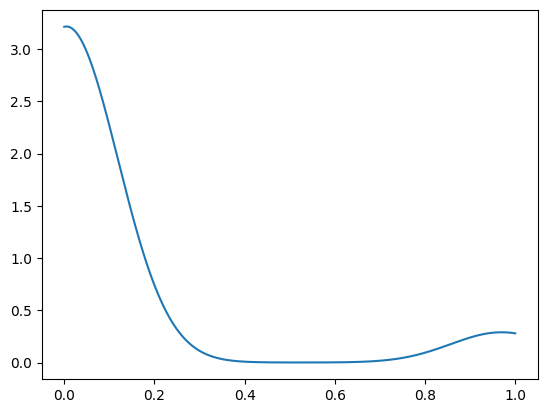

In [17]:
# plot score distribution 
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from numpy import linspace

score_list = []
for read, score in scores.items():
    score_list += score

score_list = np.array(score_list)
kde = gaussian_kde(score_list)



dist_space = linspace( 0, 1, 1000 )

plt.plot( dist_space, kde(dist_space) )

In [18]:
# vectorize kde function
vector = kde(dist_space)
print(len(vector))

1000


In [19]:
# write vector to file
with open('/data16/liam/testing/250604_JANP-112_kde_vector.txt', 'w') as f:
    for i in vector:
        f.write(str(i) + '\n')

### Score Distribution of Tad Accessible/Unaccessible Regions
#### with lower editing rates, the HMM tends to overpredict shadows. One idea we have is to introduce a tad accessibility score for kmers. This will enable us to enable multiple paths that we can iterate through with dynamic programming/backtracking algorithms to find the optimal path of shadows.
#### in real data, the accessibility score will likely be a measurement of base editor sequence preference, number of A's in kmer, and number of edits in kmer (in shadowless data)
#### in simulated data, I will just use number of As in kmer

In [ ]:
# need to compute 3mer sequence bias


In [ ]:
# reads = '/data16/liam/testing/HMM_test_data_AC50.txt'
reads = '/data16/liam/testing/HMM_test_data_20.txt'
tad_access_scores = {}

# mod_map, read_dict = build_modification_map2(f)
for read in read_dict:
    query_seq = read_dict[read]['read_string']
    ref_seq = read_dict[read]['ref_string']
    kmer_dict = {}
    for i in range(len(read_dict[read][0])-6):
        kmer = read_dict[read][0][i:i+6]
        # count number of A's in kmer
        num_A = 0
        for base in range(len(kmer)):
            if i + base in read_dict[read][2]:
                num_A += 1

        # calculate TAD access score
        tad_access_score = num_A / len(kmer)
        # calculate TAD inaccess score
        tad_inaccess_score = (len(kmer) - num_A) / len(kmer) 

        # kmer_name = ''.join(str(i) for i in kmer)
        kmer_name = str(i) + '_' + str(i+6)
        if kmer_name not in kmer_dict:
            kmer_dict[kmer_name] = (tad_access_score, tad_inaccess_score)
        # else:
        #     kmer_dict[kmer_name] = (kmer_dict[kmer_name][0] * tad_access_score, kmer_dict[kmer_name][1] * tad_inaccess_score)

    tad_access_scores[read] = kmer_dict